### 4.2 LAB Assignment
Please use the real world dataset, **California housing price**, for model training and evaluate the model’s prediction performance. You can use simple linear regression, polynomial regression or more complicated base functions such as Gaussian function or use regularization methods. Make sure at least **20% data for testing** and choose one evaluation method you think good. **Please do not just train your model and say that is good enough, you need to give your analysis**. For that end, validation or cross validation is needed. Compare the score in the training set and the validation set. If they are both good enough, then use the model on the test set.

**Your test set can only be used for final evaluation!**

In [228]:
# import the dataset

from sklearn.datasets import fetch_california_housing
import pandas as pd

ch_dataset = fetch_california_housing(as_frame=True)
ch_dataset.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


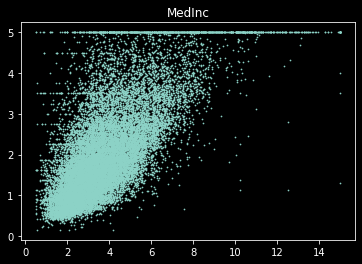

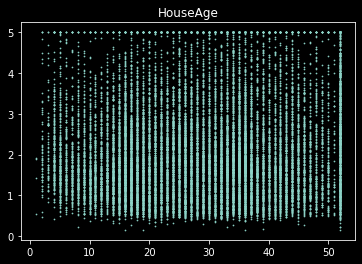

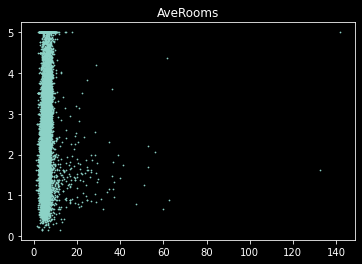

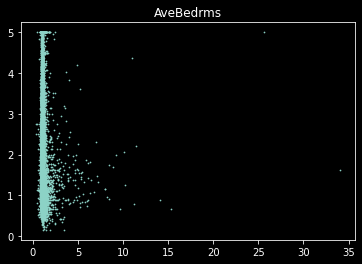

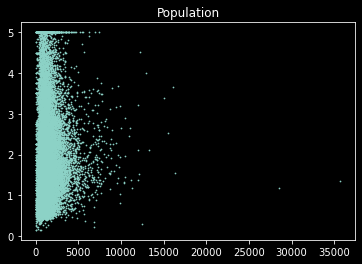

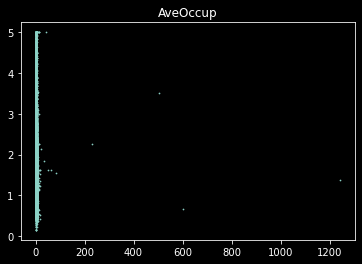

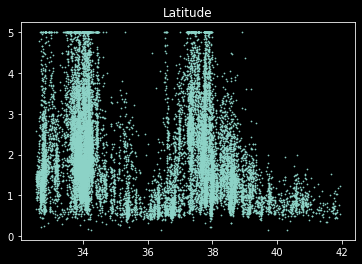

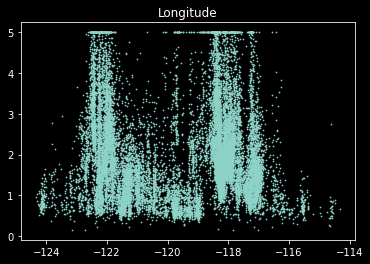

In [229]:
# visualize the data

import matplotlib.pyplot as plt

counter = 1
for feature in ch_dataset.data:
    plt.figure(counter)
    counter += 1
    plt.scatter(ch_dataset.data[feature], ch_dataset.target, s=0.5)
    plt.title(feature)
    plt.show()

In [230]:
ch_dataset.frame['HouseAge'].max()

52.0

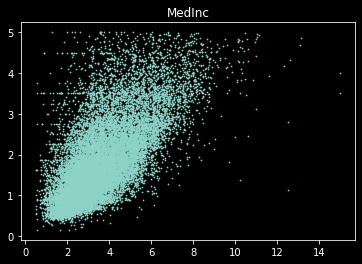

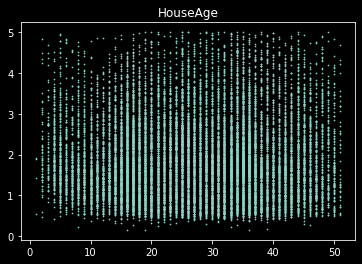

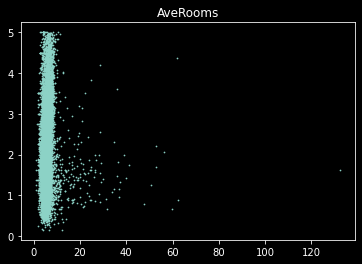

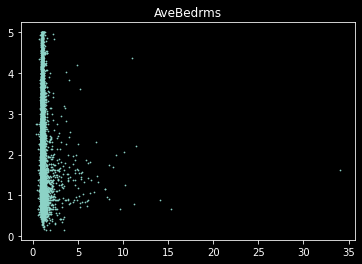

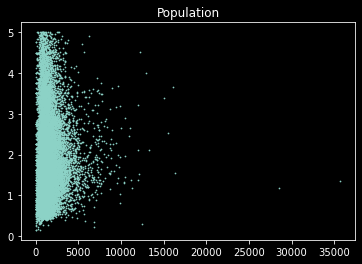

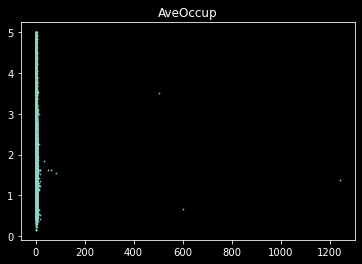

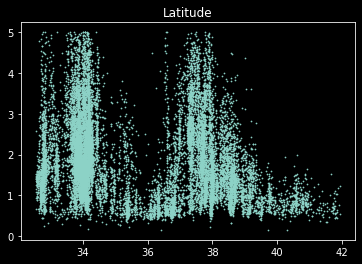

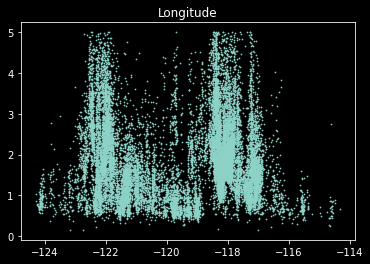

In [231]:
# clean the data

frame = ch_dataset.frame.copy()
# drop abnormal target values
frame.drop(index=frame[ch_dataset.target > 5].index, inplace=True)
# drop abnormal HouseAge values
frame.drop(index=frame[frame['HouseAge'] > 51].index, inplace=True)

counter = 1
for feature in ch_dataset.data:
    plt.figure(counter)
    counter += 1
    plt.scatter(frame[feature], frame[ch_dataset.target.name], s=0.5)
    plt.title(feature)
    plt.show()

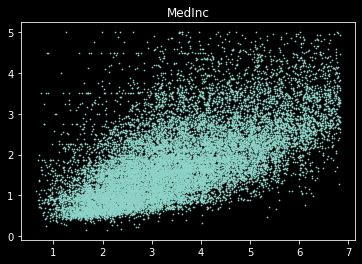

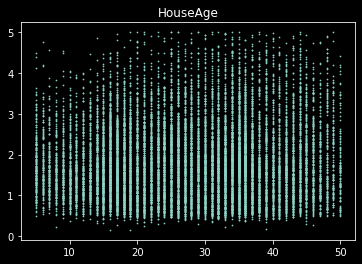

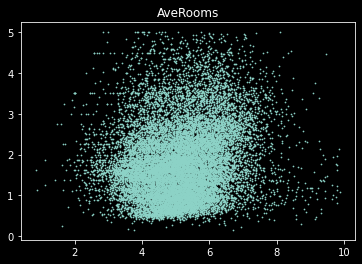

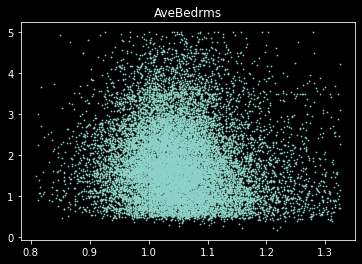

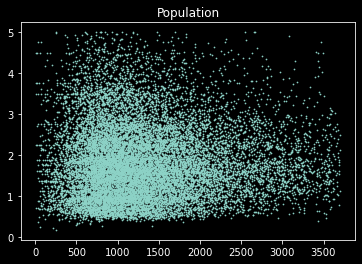

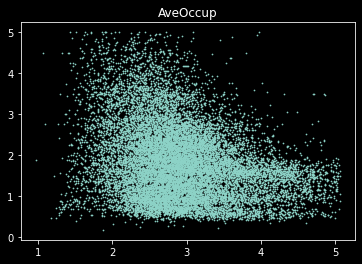

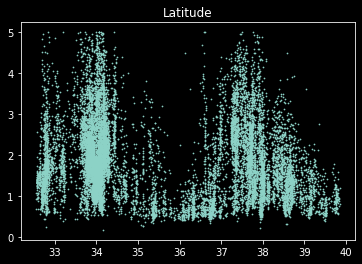

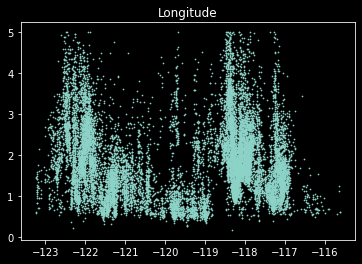

In [232]:
# outlier treatment

import numpy as np

for feature in ch_dataset.data:
    outlier_ll = np.mean(frame[feature]) - 2 * np.std(frame[feature])
    outlier_ul = np.mean(frame[feature]) + 2 * np.std(frame[feature])
    frame.drop(index=frame[frame[feature] < outlier_ll].index, inplace=True)
    frame.drop(index=frame[frame[feature] > outlier_ul].index, inplace=True)
    plt.figure(counter)
    counter += 1
    plt.scatter(frame[feature], frame[ch_dataset.target.name], s=0.5)
    plt.title(feature)
    plt.show()


In [233]:
# implement the linear regression model

import functools
import itertools

# polynomial feature processor used in regression
class PolynomialFeature():
    def __init__(self, degree:int=1):
        self.degree = degree

    def transform(self, x):
        x_t = x.transpose()
        features = [np.ones(len(x))]
        for degree in range(1, self.degree + 1):
            for items in itertools.combinations_with_replacement(x_t, degree):
                features.append(functools.reduce(lambda x, y: x * y, items))
        return np.asarray(features).transpose()

# polynomial regression class
class PolynomialRegression():
    def __init__(self, degree:int=1):
        self.degree = degree
        self.pf = PolynomialFeature(degree)
    
    def linear_fit(self, X, y):
        X = np.asmatrix(X.copy())
        y = np.asmatrix(y).reshape(-1,1)
        self.w = (X.T * X).I * X.T * y
    
    def fit(self, X, y):
        self.linear_fit(self.pf.transform(X), y)

    def linear_predict(self, X):
        X = np.asmatrix(X.copy())
        y_pred = X @ self.w
        return np.array(y_pred).ravel()
    
    def predict(self, X):
        return self.linear_predict(self.pf.transform(X))

In [234]:
# muti-degree training and K-Fold testing

from sklearn.model_selection import KFold, train_test_split

def rmse(pred, test):
    mse = np.sum((pred - test)**2)/len(test)
    return np.sqrt(mse)

def R2(pred, test):
    u = np.sum((test - pred) ** 2)
    v = np.sum((test - np.mean(test)) ** 2)
    return 1 - (u / v)


# split the dataset
frame_data = np.asanyarray(frame.drop(columns='MedHouseVal'))
frame_target = np.asanyarray(frame.MedHouseVal)
x_train, x_test,  y_train, y_test = train_test_split(frame_data, frame_target, test_size=0.2, random_state=114)

# try 0-max_degree degree fitting
max_degree = 5
k_fold = KFold(n_splits=10, shuffle=True, random_state=114)

for degree in range(max_degree + 1):
    print("degree = " + str(degree) + ":")
    model = PolynomialRegression(degree)

    # K-Fold validation
    rmses = []
    r2s = []
    for train_index, test_index in k_fold.split(x_train):
        model.fit(x_train[train_index], y_train[train_index])
        y_pred = model.predict(x_train[test_index])
        rmses.append(rmse(y_pred, y_train[test_index]))
        r2s.append(R2(y_pred, y_train[test_index]))
    
    #print("RMSEs:")
    #for item in rmses:
    #    print(item)
    print("RMSE mean: ")
    print(np.mean(rmses))
    #print("R2s:")
    #for item in r2s:
    #    print(item)
    print("R2 mean: ")
    print(np.mean(r2s))
    print("------------------")

degree = 0:
RMSE mean: 
0.9061159601417046
R2 mean: 
-0.0010386366203350317
------------------
degree = 1:
RMSE mean: 
0.572730433367485
R2 mean: 
0.5994592513875936
------------------
degree = 2:
RMSE mean: 
0.5289490786186911
R2 mean: 
0.6581436404660639
------------------
degree = 3:
RMSE mean: 
0.5127598914706494
R2 mean: 
0.6787703964837214
------------------
degree = 4:
RMSE mean: 
2.482843690169275
R2 mean: 
-26.467363145004242
------------------
degree = 5:
RMSE mean: 
66.73183524087378
R2 mean: 
-7888.08714096497
------------------


In [235]:
# degree 2 regression does the best in validation
# hence use degree 2 for test

model = PolynomialRegression(3)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
y_rmse = rmse(y_pred, y_test)
y_r2 = R2(y_pred, y_test)
print("RMSE: " + str(y_rmse))
print("R2: " + str(y_r2))

RMSE: 0.4748702077673571
R2: 0.7071454433906943


### Evaluation

I train the `Polynomial Regression` model from `degree 0 to degree 5`, and score the model with `RMSE` and `R2-Score`. I am using `K-Fold Cross Validation`.

It comes out that the model performs the best at `degree 3`, with an average `RMSE` of `0.5127598914706494` and an average `R2` of `0.6787703964837214`.

Consider that the target values range from 0 to 5, and the RMSE is at a scale of `10%` with regard to it. I think this is a rather good performance.

Good R2-Scores are within `[0,1]`, the closer to 1 the better. `0.68+` is acceptable.

----

Then I train the model with the whole training dataset at `degree 3`, and test it with the testing dataset.

The `RMSE` comes down to `0.4748702077673571`, and the `R2` goes up to `0.7071454433906943`.

It performs better than in the validation, which conforms to my expectation. Hence I accept this as a successful try.

### 4.3 Questions
1) Describe another real-world application where the regression method can be applied.

  - `Predicting the chance to sprain one's foot according to the distance he walks.`

2) What are the strengths of the linear/polynomial regression methods; when do they perform well?

  - `Super fast.`
  - `Easy to understand.`

  `It performs well when the relationship between the data and the target is simple polynomial.`

3) What are the weaknesses of the linear/polynomial regression methods; when do they perform poorly?

  - `Not very precise.`
  - `Depends relatively heavily on the preprocessing.`

  `It performs poorly when the relationship is not simple polynomial, and when the dataset is dirty.`

4) What makes the linear regression method a good candidate for the regression problem, if you have enough knowledge about the data?

  `When we have only several features that matter, and the relationship between them and the target is simple, we want to remain simple and easy to explain, or we just want some fast and simple result first, then linear regression will be a good choice.`